# Random Forest Model Analysis for Malware Detection

Detailed analysis and deployment preparation for the best-performing Random Forest model from the model comparison study.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_curve, auc, precision_recall_curve,
                           average_precision_score)
from joblib import load, dump

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting style
plt.style.use('default')
sns.set_style('whitegrid')

In [11]:
# Load and preprocess data
print("Loading and preprocessing data...")
df = pd.read_csv('malware_detection_features.csv')
X = df.drop('label', axis=1)
y = df['label']

# Scale features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("\nDataset shapes:")
print(f"Training: {X_train.shape}")
print(f"Test: {X_test.shape}")

# Train Random Forest model
print("\nTraining Random Forest model...")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Get predictions for optimal threshold
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Find optimal threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Save model and metadata
model_info = {
    'model': rf_model,
    'optimal_threshold': optimal_threshold,
    'feature_names': list(X.columns),
    'scaler': scaler
}

dump(model_info, 'random_forest_model.joblib')
print(f"\nModel saved with optimal threshold: {optimal_threshold:.3f}")

# Print initial performance
print("\nInitial Model Performance:")
print(classification_report(y_test, y_pred))

Loading and preprocessing data...

Dataset shapes:
Training: (8000, 10)
Test: (2000, 10)

Training Random Forest model...

Model saved with optimal threshold: 0.560

Initial Model Performance:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      1000
           1       0.93      0.92      0.92      1000

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000


Model saved with optimal threshold: 0.560

Initial Model Performance:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      1000
           1       0.93      0.92      0.92      1000

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



## Model Performance Analysis

1. Confusion Matrix
2. ROC Curve with Optimal Threshold
3. Precision-Recall Curve
4. Feature Importance Analysis
5. Detailed Metrics at Various Thresholds

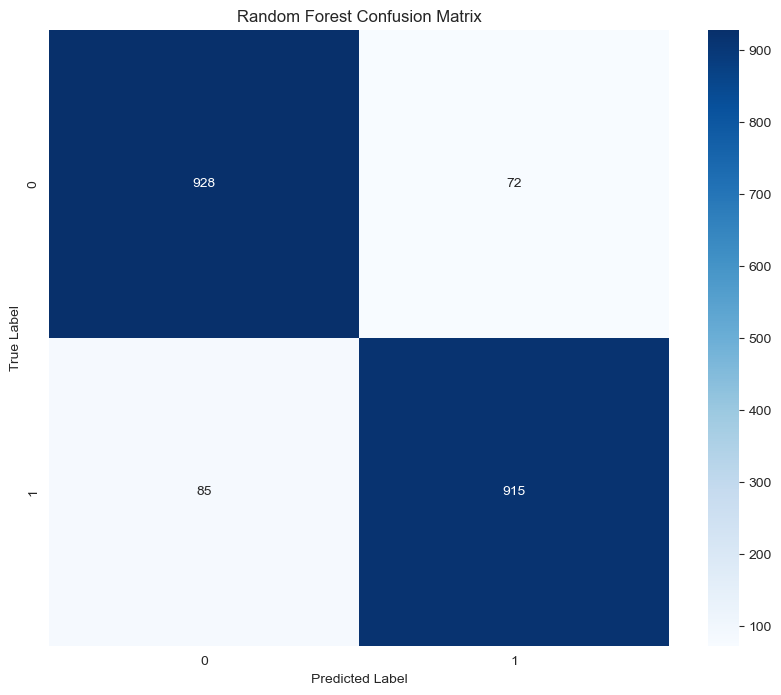


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      1000
           1       0.93      0.92      0.92      1000

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



In [12]:
# Get predictions and probabilities
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

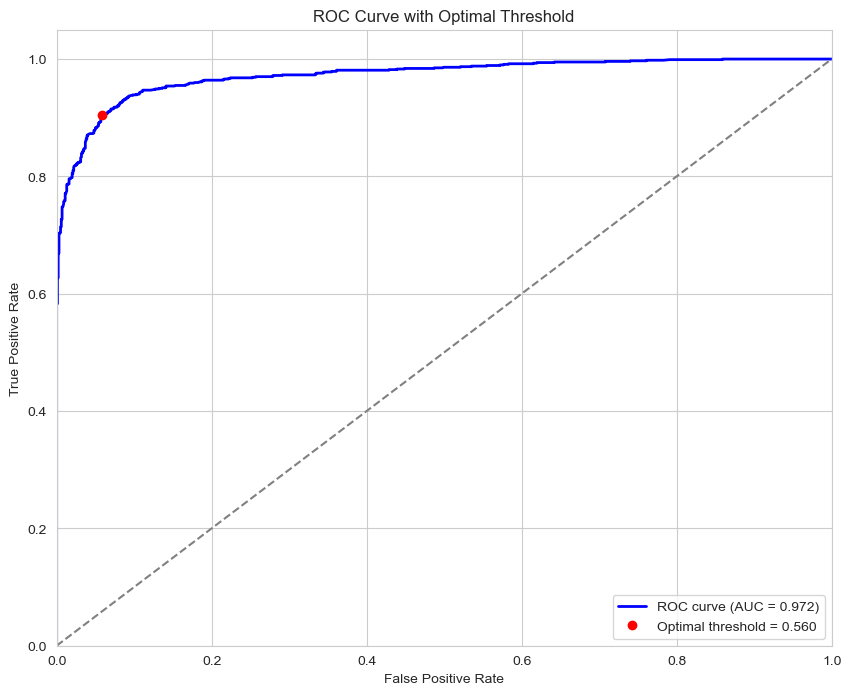

In [13]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.plot(fpr[np.argmax(tpr - fpr)], tpr[np.argmax(tpr - fpr)], 'ro',
         label=f'Optimal threshold = {optimal_threshold:.3f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Optimal Threshold')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

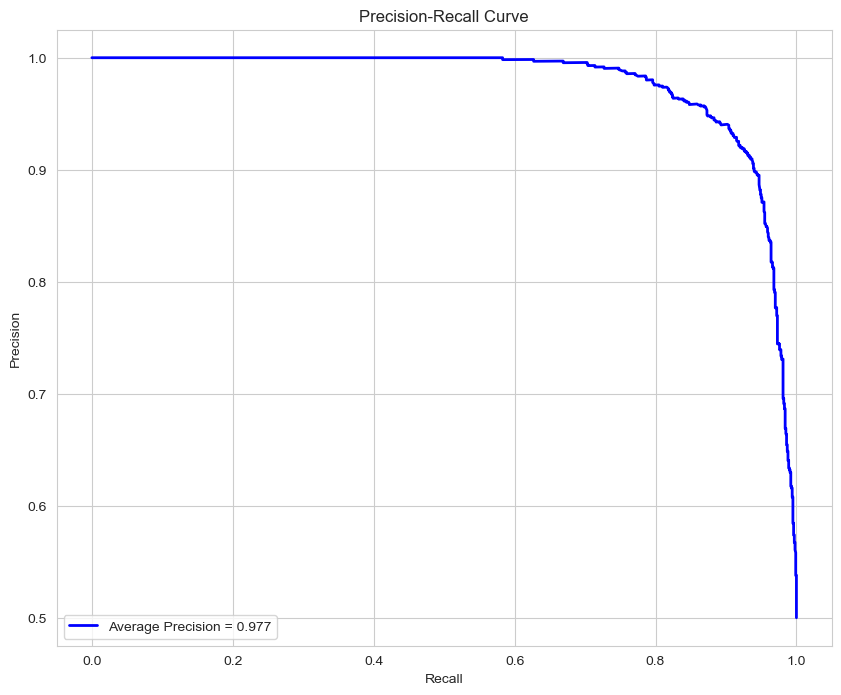

In [14]:
# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='blue', lw=2,
         label=f'Average Precision = {avg_precision:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

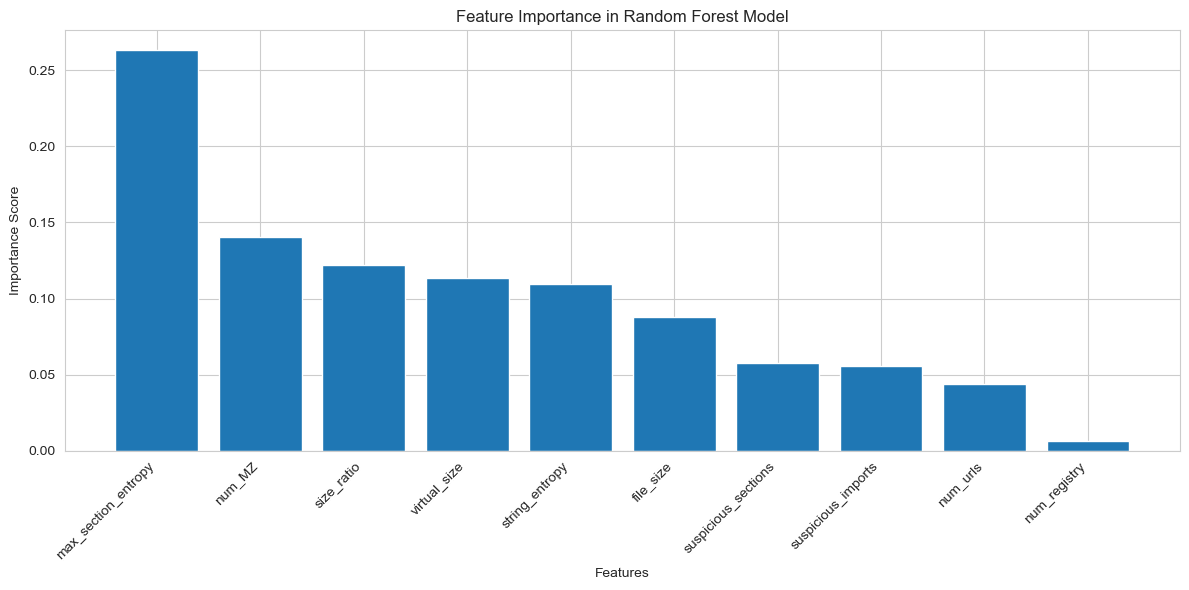


Top 10 Most Important Features:
1. max_section_entropy: 0.2632
2. num_MZ: 0.1405
3. size_ratio: 0.1224
4. virtual_size: 0.1135
5. string_entropy: 0.1097
6. file_size: 0.0877
7. suspicious_sections: 0.0576
8. suspicious_imports: 0.0554
9. num_urls: 0.0439
10. num_registry: 0.0063


In [15]:
# Feature importance analysis
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Get the number of features to display (min of 20 or total features)
n_features = min(20, len(importances))

plt.figure(figsize=(12, 6))
plt.title('Feature Importance in Random Forest Model')
plt.bar(range(n_features), importances[indices][:n_features])
plt.xticks(range(n_features), [X.columns[i] for i in indices][:n_features], rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()

# Print top features (up to 10)
n_top = min(10, len(importances))
print(f"\nTop {n_top} Most Important Features:")
for i in range(n_top):
    print(f"{i+1}. {X.columns[indices[i]]}: {importances[indices[i]]:.4f}")

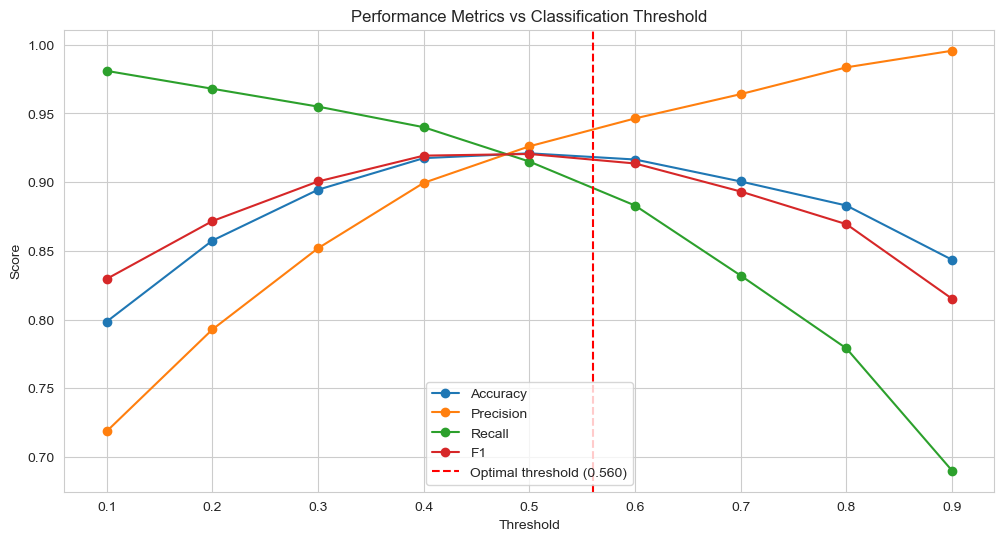


Metrics at optimal threshold:
Accuracy: 0.916
Precision: 0.946
Recall: 0.883
F1: 0.914


In [16]:
# Threshold analysis
thresholds = np.arange(0.1, 1.0, 0.1)
metrics = []

for threshold in thresholds:
    y_pred_th = (y_pred_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_th).ravel()
    
    metrics.append({
        'Threshold': threshold,
        'Accuracy': (tp + tn) / (tp + tn + fp + fn),
        'Precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
        'Recall': tp / (tp + fn) if (tp + fn) > 0 else 0,
        'F1': 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0,
        'False Positive Rate': fp / (fp + tn) if (fp + tn) > 0 else 0
    })

metrics_df = pd.DataFrame(metrics)

# Plot metrics vs threshold
plt.figure(figsize=(12, 6))
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1']
for metric in metrics_to_plot:
    plt.plot(metrics_df['Threshold'], metrics_df[metric], 
             marker='o', label=metric)
plt.axvline(x=optimal_threshold, color='r', linestyle='--', 
            label=f'Optimal threshold ({optimal_threshold:.3f})')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Performance Metrics vs Classification Threshold')
plt.legend()
plt.grid(True)
plt.show()

print("\nMetrics at optimal threshold:")
optimal_metrics = metrics_df.iloc[(metrics_df['Threshold'] - optimal_threshold).abs().argsort()[0]]
for metric in metrics_to_plot:
    print(f"{metric}: {optimal_metrics[metric]:.3f}")

## Model Deployment Guide

### Loading and Using the Model

```python
from joblib import load
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load model and metadata
model_info = load('random_forest_model.joblib')
model = model_info['model']
optimal_threshold = model_info['optimal_threshold']
feature_names = model_info['feature_names']

# Function for making predictions
def predict_malware(X_new, threshold=None):
    """
    Make predictions on new data
    
    Parameters:
    X_new : array-like of shape (n_samples, n_features)
        New samples to predict
    threshold : float, optional
        Custom threshold for classification. If None, uses optimal threshold
    
    Returns:
    predictions : array of shape (n_samples,)
        Predicted labels (0 for benign, 1 for malware)
    probabilities : array of shape (n_samples,)
        Probability of being malware
    """
    if threshold is None:
        threshold = optimal_threshold
        
    # Ensure features match
    if not isinstance(X_new, pd.DataFrame):
        X_new = pd.DataFrame(X_new, columns=feature_names)
    
    # Get probabilities
    proba = model.predict_proba(X_new)[:, 1]
    
    # Make predictions using threshold
    predictions = (proba >= threshold).astype(int)
    
    return predictions, proba
```

### Important Notes:
1. Feature names and order must match the training data
2. Features should be scaled using the same scaler
3. The optimal threshold can be adjusted based on specific needs:
   - Higher threshold: Better precision (fewer false positives)
   - Lower threshold: Better recall (fewer false negatives)

## Flask Web Application Integration

Below is the code that demonstrates how to integrate our Random Forest model with the Flask web application (`app.py`). This shows how the model is loaded and used in the web interface.

In [ ]:
# Example of Flask integration (app.py)
from flask import Flask, request, render_template, jsonify
import pandas as pd
import numpy as np
from joblib import load

def create_flask_app():
    """Create and configure Flask application with Random Forest model"""
    app = Flask(__name__)
    
    # Load the trained model and metadata
    model_info = load('random_forest_model.joblib')
    model = model_info['model']
    optimal_threshold = model_info['optimal_threshold']
    feature_names = model_info['feature_names']
    scaler = model_info['scaler']
    
    @app.route('/')
    def home():
        # Get feature importance data
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        top_features = [
            {'name': feature_names[i], 'importance': float(importances[i])}
            for i in indices[:10]
        ]
        
        return render_template('index.html', 
                             feature_names=feature_names,
                             top_features=top_features,
                             threshold=float(optimal_threshold))
    
    @app.route('/predict', methods=['POST'])
    def predict():
        try:
            # Get features from request
            content = request.json
            features_df = pd.DataFrame([content], columns=feature_names)
            
            # Scale features using the same scaler used during training
            features_scaled = scaler.transform(features_df)
            
            # Use the predict_malware function
            predictions, probabilities = predict_malware(
                features_scaled, threshold=optimal_threshold
            )
            
            # Get feature contributions
            feature_importance = model.feature_importances_
            feature_contributions = features_scaled[0] * feature_importance
            
            # Get top contributing features
            top_contributors = sorted(
                zip(feature_names, feature_contributions),
                key=lambda x: abs(x[1]),
                reverse=True
            )[:5]
            
            return jsonify({
                'status': 'success',
                'prediction': int(predictions[0]),
                'probability': float(probabilities[0]),
                'threshold': float(optimal_threshold),
                'top_contributors': [
                    {'feature': feat, 'contribution': float(cont)}
                    for feat, cont in top_contributors
                ]
            })
            
        except Exception as e:
            return jsonify({
                'status': 'error',
                'message': str(e)
            }), 400
    
    return app

# Example usage
if __name__ == '__main__':
    app = create_flask_app()
    app.run(debug=True)

print("The code above shows how to integrate the Random Forest model with Flask.")
print("Key integration points:")
print("1. Model is loaded from random_forest_model.joblib")
print("2. predict_malware function is used for predictions")
print("3. Feature scaling is preserved using the same scaler")
print("4. Optimal threshold is applied for classification")
print("5. Feature importance is shown in the web interface")

 * Serving Flask app '__main__'
 * Debug mode: on
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (windowsapi)

 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (windowsapi)


SystemExit: 1

c:\Users\thinkbook\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


: 

### Using the Web Application

To use the web application:

1. Make sure the model is saved:
   ```python
   dump(model_info, 'random_forest_model.joblib')
   ```

2. Run the Flask application:
   ```bash
   python app.py
   ```

3. Access the web interface at http://localhost:5000

The web interface provides:
- Feature importance visualization
- Real-time predictions
- Probability scores
- Top contributing features for each prediction
- Adjustable threshold settings

### Flask Application Startup Guide

To properly start the Flask application and avoid multiple instances, use the following approach:

In [ ]:
# Save this as run_app.py
from flask import Flask
import os
import signal

def run_flask_app():
    """
    Run Flask application with proper startup handling
    """
    try:
        # Check if the model file exists
        if not os.path.exists('random_forest_model.joblib'):
            raise FileNotFoundError("Model file 'random_forest_model.joblib' not found!")
            
        # Create and run the Flask app
        from app import create_flask_app
        app = create_flask_app()
        
        # Set host to localhost only for security
        app.run(host='127.0.0.1', port=5000, debug=True)
        
    except KeyboardInterrupt:
        print("\nShutting down gracefully...")
        # Handle Ctrl+C gracefully
        os.kill(os.getpid(), signal.SIGTERM)
    except Exception as e:
        print(f"Error starting the application: {str(e)}")
        
if __name__ == '__main__':
    run_flask_app()

print("To run the application:")
print("1. Save the code above as 'run_app.py'")
print("2. Run it using: python run_app.py")
print("3. Access the web interface at http://127.0.0.1:5000")
print("\nTo stop the server: Press Ctrl+C in the terminal")

Now let's create a proper startup script:

1. First, make sure to stop any running Flask instances:
   ```powershell
   Stop-Process -Name "python" -Force  # Only if needed to stop existing instances
   ```

2. Create the run_app.py file with the code above

3. Start the application:
   ```powershell
   python run_app.py
   ```

This approach:
- Ensures only one server instance runs
- Provides proper error handling
- Handles graceful shutdown
- Checks for model file existence
- Restricts access to localhost only